In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
#pd.set_option('display.max_rows', None)

from IPython.core.display import display, HTML

In [2]:
price_df = pd.read_csv('zillow-yearly-ca.csv').rename(columns={'RegionName': 'county'})
price_df['county'] = price_df['county'].apply(lambda x: x.replace(' County', ''))
price_df['fips_code'] = price_df.apply(lambda x: f'{x.fips_code:05}', axis=1).tolist()
display(price_df)
print(f'Number of counties: {len(price_df.fips_code.unique())}')

,fips_code,county,year,price
0,06001,Alameda,2000,302255.314092
1,06001,Alameda,2001,368098.179928
2,06001,Alameda,2002,393708.303015
3,06001,Alameda,2003,427010.475210
4,06001,Alameda,2004,484363.003599
...,...,...,...,...
1387,06115,Yuba,2019,291275.185476
1388,06115,Yuba,2020,314465.065842
1389,06115,Yuba,2021,371635.057158
1390,06115,Yuba,2022,413854.162305


Number of counties: 58


In [3]:
income_df = pd.read_csv('Income_with_FIPS.csv').rename(columns={'taxable_year': 'year'})
income_df['fips_code'] = income_df.apply(lambda x: f'{x.fp:05}', axis=1).tolist()
income_df = income_df[['fips_code', 'year', 'county', 'population', 'median_income']]
display(income_df)
print(f'Number of counties: {len(income_df.fips_code.unique())}')

,fips_code,year,county,population,median_income
0,06001,1995,Alameda,1347700,28329
1,06003,1995,Alpine,1200,23999
2,06005,1995,Amador,32600,24729
3,06007,1995,Butte,196100,20036
4,06009,1995,Calaveras,36950,23563
...,...,...,...,...,...
1503,06107,2020,Tulare,473482,30151
1504,06109,2020,Tuolumne,55500,39102
1505,06111,2020,Ventura,844545,44494
1506,06113,2020,Yolo,216544,44881


Number of counties: 58


In [4]:
burn_df = pd.read_csv('cleaned_fire_percent.csv').rename(columns={'YEAR_': 'year', 'NAMELSAD': 'county'})
burn_df['county'] = burn_df['county'].apply(lambda x: x.replace(' County', ''))
fips = burn_df.apply(lambda x: f'{x.STATEFP:02}{x.COUNTYFP:03}', axis=1).tolist()
burn_df.insert(0, 'fips_code', fips)
burn_df = burn_df[['fips_code', 'year', 'county', 'total_burn_pyr', 'perc_burn']]
burn_df['year'] = burn_df['year'].astype(int)
display(burn_df)
print(f'Number of counties: {len(burn_df.fips_code.unique())}')

,fips_code,year,county,total_burn_pyr,perc_burn
0,06091,2000,Sierra,6.748577e+04,0.002711
1,06091,2001,Sierra,2.753879e+06,0.110615
2,06091,2003,Sierra,2.429302e+05,0.009758
3,06091,2004,Sierra,1.117228e+06,0.044876
4,06091,2005,Sierra,9.159885e+06,0.367926
...,...,...,...,...,...
1081,06079,2018,San Luis Obispo,5.988013e+06,0.063943
1082,06079,2019,San Luis Obispo,2.196040e+07,0.234503
1083,06079,2020,San Luis Obispo,4.020842e+07,0.429363
1084,06079,2021,San Luis Obispo,8.947344e+05,0.009554


Number of counties: 57


In [5]:
input_df = price_df.merge(income_df, on=['fips_code', 'year', 'county']).merge(burn_df, on=['fips_code', 'year', 'county'])
print(f'Number of counties: {len(input_df.fips_code.unique())}')
display(input_df)
input_df = input_df.drop(columns=['county'])

Number of counties: 55


,fips_code,county,year,price,population,median_income,total_burn_pyr,perc_burn
0,06001,Alameda,2000,302255.314092,1466900,37580,3.052264e+05,0.014358
1,06001,Alameda,2001,368098.179928,1479300,38582,4.758508e+05,0.022384
2,06001,Alameda,2002,393708.303015,1488000,38044,1.230661e+06,0.057891
3,06001,Alameda,2003,427010.475210,1493928,38411,1.642332e+07,0.772567
4,06001,Alameda,2005,585124.011579,1502703,40613,2.040273e+07,0.959761
...,...,...,...,...,...,...,...,...
959,06115,Yuba,2016,223107.534460,76138,32937,2.255334e+06,0.135335
960,06115,Yuba,2017,248179.174297,76767,33537,5.347435e+07,3.208806
961,06115,Yuba,2018,273093.321349,77426,34903,2.818490e+05,0.016913
962,06115,Yuba,2019,291275.185476,79089,36246,9.799734e+05,0.058805


In [6]:
# Join last 3 year data per row
N = 3
df = input_df
for lag in range(1, N+1):
    shifted = input_df.groupby(by=['fips_code']).shift(lag).drop(columns=['year'])
    df = df.join(shifted.rename(columns=lambda x: f"{x}-prev_{lag}"))
df = df.drop(columns=input_df.columns[3:])
# Remove the first N rows since it doesn't have data from previous N years to make prediction
df = df[~df.isnull().any(axis=1)].reset_index(drop=True)
display(df)

,fips_code,year,price,price-prev_1,population-prev_1,median_income-prev_1,total_burn_pyr-prev_1,perc_burn-prev_1,price-prev_2,population-prev_2,median_income-prev_2,total_burn_pyr-prev_2,perc_burn-prev_2,price-prev_3,population-prev_3,median_income-prev_3,total_burn_pyr-prev_3,perc_burn-prev_3
0,06001,2003,427010.475210,393708.303015,1488000.0,38044.0,1.230661e+06,0.057891,368098.179928,1479300.0,38582.0,4.758508e+05,0.022384,302255.314092,1466900.0,37580.0,3.052264e+05,0.014358
1,06001,2005,585124.011579,427010.475210,1493928.0,38411.0,1.642332e+07,0.772567,393708.303015,1488000.0,38044.0,1.230661e+06,0.057891,368098.179928,1479300.0,38582.0,4.758508e+05,0.022384
2,06001,2006,627743.227682,585124.011579,1502703.0,40613.0,2.040273e+07,0.959761,427010.475210,1493928.0,38411.0,1.642332e+07,0.772567,393708.303015,1488000.0,38044.0,1.230661e+06,0.057891
3,06001,2010,446991.395343,627743.227682,1513859.0,42360.0,9.687559e+06,0.455711,585124.011579,1502703.0,40613.0,2.040273e+07,0.959761,427010.475210,1493928.0,38411.0,1.642332e+07,0.772567
4,06001,2011,412947.214791,446991.395343,1513493.0,41936.0,1.855574e+06,0.087288,627743.227682,1513859.0,42360.0,9.687559e+06,0.455711,585124.011579,1502703.0,40613.0,2.040273e+07,0.959761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,06115,2016,223107.534460,201031.065279,75579.0,32059.0,1.055827e+06,0.063356,184355.467429,74977.0,31976.0,1.340760e+05,0.008045,152049.332163,72994.0,31545.0,2.384977e+06,0.143114
795,06115,2017,248179.174297,223107.534460,76138.0,32937.0,2.255334e+06,0.135335,201031.065279,75579.0,32059.0,1.055827e+06,0.063356,184355.467429,74977.0,31976.0,1.340760e+05,0.008045
796,06115,2018,273093.321349,248179.174297,76767.0,33537.0,5.347435e+07,3.208806,223107.534460,76138.0,32937.0,2.255334e+06,0.135335,201031.065279,75579.0,32059.0,1.055827e+06,0.063356
797,06115,2019,291275.185476,273093.321349,77426.0,34903.0,2.818490e+05,0.016913,248179.174297,76767.0,33537.0,5.347435e+07,3.208806,223107.534460,76138.0,32937.0,2.255334e+06,0.135335


Number of features: 15
Train: 479
Test: 320
RMSE: 2903545477.35
RMSLE: 0.03


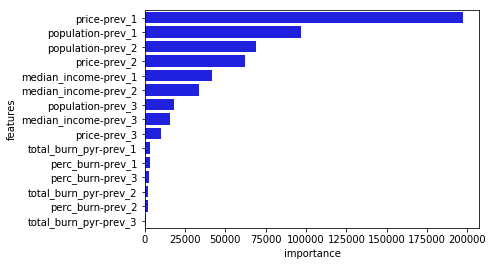

In [10]:
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error


feat_cols = df.columns[3:]
X = df[feat_cols].values
y = df.price

# Random split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
print(f'Number of features: {len(feat_cols)}')
print(f'Train: {len(X_train)}')
print(f'Test: {len(X_test)}')

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)
y_test_predict = model.predict(X_test_scaled)
rmse = mean_squared_error(y_test, y_test_predict)
rmsle = mean_squared_log_error(y_test, y_test_predict)
print(f'RMSE: {rmse:.2f}')
print(f'RMSLE: {rmsle:.2f}')

lg_importances = pd.DataFrame(data={
    'features': feat_cols,
    'importance': abs(model.coef_)
})
lg_importances = lg_importances.sort_values(by='importance', ascending=False)
#display(lg_importances)

sns.barplot(x="importance", y="features", data=lg_importances, label="Feature Importance", color="b")
plt.show()

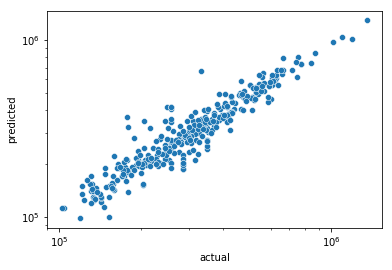

In [8]:
# Plot actual vs. predicted in log-scale
res_df = pd.DataFrame(np.vstack([y_test, y_test_predict]).T, columns=['actual', 'predicted'])
sns.scatterplot(data=res_df, x='actual', y='predicted')
plt.xscale('log')
plt.yscale('log')